# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Постановка задачи

В нашем распоряжении данные из объявлений о продаже автомобилей.  
Необходимо построить модель обучения для эффективного определения стоимости автомобиля.

Необходимо рассмотреть работу нескольких моделей машиного обучения, выбрать наилучшую по показателю RMSE и скорости обучения.  
Целевая задача, чтобы метрика RMSE была менее 2500.

## Подготовка данных

In [8]:
!pip install phik

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error

import phik
from phik.report import plot_correlation_matrix, correlation_report

In [10]:
data = pd.read_csv('autos.csv')

### Проведем предобработку и исследоватеьский анализ данных

In [11]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### Проверим на наличие явных дубликатов

In [13]:
display(f'Количество явных дубликатов {data.duplicated().sum()}')
data.drop_duplicates(inplace=True) #удалим если дубликаты найдены

'Количество явных дубликатов 4'

#### Посмотрим разброс значнений целевого признака

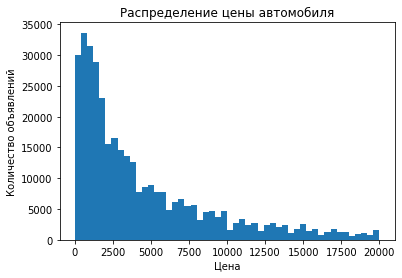

In [14]:
data['Price'].plot(kind='hist', bins=(50), range=(data['Price'].min(),data['Price'].max()))
plt.title('Распределение цены автомобиля')
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')
plt.show()

In [15]:
# выведем на экран объяления с ценой автомобилей до 100 евро
data[data['Price'] < 100]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09 00:00:00,0,91301,2016-04-06 22:15:32


In [16]:
# оставим в датасете только объявление с ценой автомобиля свыше 100 евро. Остальные посчитаем "ошибкой" в данных.
data = data[data['Price']>=100]

#### Обработаем пропуски в данных

In [17]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          32612
RegistrationYear         0
Gearbox              16314
Power                    0
Model                17033
Kilometer                0
RegistrationMonth        0
FuelType             28349
Brand                    0
Repaired             64357
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

##### Обработаем пропуски в столбце **VehicleType** = тип кузова

In [18]:
data[data['VehicleType'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13


Проверим можно ли заполнить столбец **VehicleType**, если известен **Brand и Model**

In [19]:
data.pivot_table(index=['Brand','Model','VehicleType'], values='NumberOfPictures', aggfunc='sum').reset_index()

,Brand,Model,VehicleType,NumberOfPictures
0,alfa_romeo,145,coupe,0
1,alfa_romeo,145,other,0
2,alfa_romeo,145,sedan,0
3,alfa_romeo,145,small,0
4,alfa_romeo,147,coupe,0
...,...,...,...,...
1392,volvo,v70,coupe,0
1393,volvo,v70,wagon,0
1394,volvo,xc_reihe,sedan,0
1395,volvo,xc_reihe,suv,0


Вывод: Нельзя заполнить столбец  **VehicleType**, если известен **Brand и Model**, т.к. из таблицы видно, что одна и таже марка автомобиля одинаковой модели может иметь разный тип кузова.  
Заполним пропуски "загрушкой" = unknown

In [20]:
data['VehicleType'].value_counts()

sedan          89087
small          77443
wagon          63464
bus            28265
convertible    19817
coupe          15553
suv            11762
other           3048
Name: VehicleType, dtype: int64

In [21]:
data.loc[data['VehicleType'].isna(),'VehicleType'] = 'unknown'

In [22]:
data['VehicleType'].value_counts()

sedan          89087
small          77443
wagon          63464
unknown        32612
bus            28265
convertible    19817
coupe          15553
suv            11762
other           3048
Name: VehicleType, dtype: int64

##### Обработаем пропуски в столбце **Gearbox** = коробка передач

In [23]:
data[data['Gearbox'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,unknown,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,unknown,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16 00:00:00,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,unknown,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,unknown,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


Заполним пропуски "загрушкой" = unknown

In [24]:
data.loc[data['Gearbox'].isna(),'Gearbox'] = 'unknown'

In [25]:
data['Gearbox'].value_counts()

manual     260072
auto        64665
unknown     16314
Name: Gearbox, dtype: int64

##### Обработаем пропуски в столбце **Model** = модель

In [26]:
data[data['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
151,2016-03-27 20:47:22,6799,small,2009,unknown,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,89077,2016-03-27 20:47:22
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07 00:00:00,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15 00:00:00,0,91186,2016-03-17 08:16:25
354338,2016-03-31 19:52:33,180,unknown,1995,unknown,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354351,2016-03-11 23:40:32,1900,unknown,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51


Заполним пропуски "загрушкой" = unknown

In [27]:
data.loc[data['Model'].isna(),'Model'] = 'unknown'

In [28]:
data['Model'].value_counts()

golf                  28086
other                 23499
3er                   19074
unknown               17033
polo                  12511
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 251, dtype: int64

##### Обработаем пропуски в столбце **FuelType** = тип топлива

In [29]:
data[data['FuelType'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
13,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21 00:00:00,0,90762,2016-03-23 02:50:54
26,2016-03-10 19:38:18,5555,unknown,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,33649,2016-04-03 11:44:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354339,2016-03-20 12:46:00,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no,2016-03-20 00:00:00,0,53947,2016-03-26 21:18:23
354346,2016-03-07 17:06:35,2600,unknown,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354351,2016-03-11 23:40:32,1900,unknown,2000,manual,110,unknown,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51
354361,2016-03-09 13:37:43,5250,unknown,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13


Заполним пропуски "загрушкой" = unknown

In [30]:
data.loc[data['FuelType'].isna(),'FuelType'] = 'unknown'

In [31]:
data['FuelType'].value_counts()

petrol      209595
gasoline     96936
unknown      28349
lpg           5155
cng            549
hybrid         226
other          154
electric        87
Name: FuelType, dtype: int64

##### Обработаем пропуски в столбце **Repaired** = была ли в ремонте

In [32]:
data[data['Repaired'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
12,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,37269,2016-04-01 13:16:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354349,2016-03-16 17:06:19,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,2016-03-16 00:00:00,0,56472,2016-03-18 11:30:17
354356,2016-04-04 11:45:16,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,2016-04-04 00:00:00,0,88477,2016-04-06 12:44:52
354357,2016-03-09 11:36:55,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,2016-03-09 00:00:00,0,18246,2016-04-04 08:15:30
354365,2016-03-14 17:48:27,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52


Заполним пропуски "загрушкой" = unknown

In [33]:
data.loc[data['Repaired'].isna(),'Repaired'] = 'unknown'

In [34]:
data['Repaired'].value_counts()

no         243203
unknown     64357
yes         33491
Name: Repaired, dtype: int64

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341051 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        341051 non-null  object
 1   Price              341051 non-null  int64 
 2   VehicleType        341051 non-null  object
 3   RegistrationYear   341051 non-null  int64 
 4   Gearbox            341051 non-null  object
 5   Power              341051 non-null  int64 
 6   Model              341051 non-null  object
 7   Kilometer          341051 non-null  int64 
 8   RegistrationMonth  341051 non-null  int64 
 9   FuelType           341051 non-null  object
 10  Brand              341051 non-null  object
 11  Repaired           341051 non-null  object
 12  DateCreated        341051 non-null  object
 13  NumberOfPictures   341051 non-null  int64 
 14  PostalCode         341051 non-null  int64 
 15  LastSeen           341051 non-null  object
dtypes: int64(7), object(

##### Обработаем столбец **RegistrationYear** = год регистрации автомобиля

In [36]:
# выведем основные статистики
data['RegistrationYear'].describe()

count    341051.000000
mean       2003.955335
std          69.812151
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

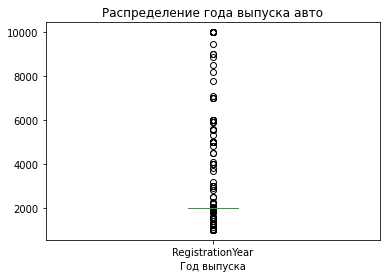

In [37]:
data['RegistrationYear'].plot(kind='box')
plt.title('Распределение года выпуска авто')
plt.xlabel('Год выпуска')
plt.show()

Создадим столбец **year_create**, в который сохраним год создания объявления.  
Далее удалим из датасета все объявления, в которых год выпуска авто больше чем год создания объявления, таким образом удалим некорректные данные по верхней границе года выпуска автомобиля.

In [38]:
data['year_create'] = pd.to_datetime(data.DateCreated).dt.year
data['year_create']

0         2016
1         2016
2         2016
3         2016
4         2016
          ... 
354363    2016
354365    2016
354366    2016
354367    2016
354368    2016
Name: year_create, Length: 341051, dtype: int64

In [39]:
data = data[data['RegistrationYear'] <= data['year_create']]

Удалим объявления, в которых год выпуск авто ранее 1950 года. Это раритетные экспонаты или ошибки в данных

In [40]:
data = data[(data['RegistrationYear'] > 1950)]

##### Обработаем столбец **Power** = мощность автомобиля

In [41]:
data['Power'].describe()

count    327205.000000
mean        112.363515
std         185.296699
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

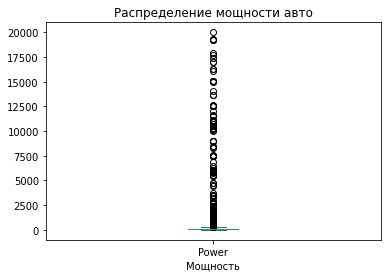

In [42]:
data['Power'].plot(kind='box')
plt.title('Распределение мощности авто')
plt.xlabel('Мощность')
plt.show()

Выведем объявления, в которых мощность менее 30

In [43]:
data[data['Power'] < 30]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,year_create
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016
32,2016-03-15 20:59:01,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43,2016
37,2016-03-28 17:50:15,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02,2016
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,unknown,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32,2016
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26 00:00:00,0,56759,2016-04-01 23:17:27,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,unknown,1995,unknown,0,unknown,125000,3,petrol,opel,unknown,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04,2016
354346,2016-03-07 17:06:35,2600,unknown,2005,auto,0,c_klasse,150000,9,unknown,mercedes_benz,unknown,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38,2016
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12,2016
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23,2016


Удалим из датасета объявления, если мощность автомобиля менее 30 или больше 500, посчитаем, что это выбросы

In [44]:
data = data[(data['Power'] > 30)&(data['Power'] < 500)]

In [45]:
data['Power'].describe()

count    294402.000000
mean        120.810297
std          53.173042
min          31.000000
25%          77.000000
50%         112.000000
75%         150.000000
max         490.000000
Name: Power, dtype: float64

##### Обработаем столбец **Kilometer** = пробег автомобеля

In [46]:
data['Kilometer'].describe()

count    294402.000000
mean     128460.947956
std       36547.528977
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

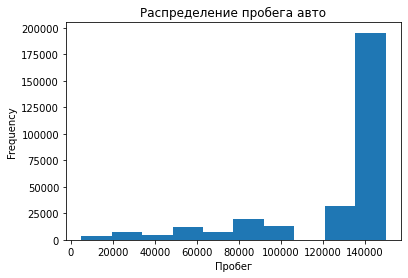

In [47]:
data['Kilometer'].plot(kind='hist')
plt.title('Распределение пробега авто')
plt.xlabel('Пробег')
plt.show()

##### Обработаем столбец **NumberOfPictures** = количество фотографий

In [48]:
data['NumberOfPictures'].value_counts()

0    294402
Name: NumberOfPictures, dtype: int64

Вывод - во всех объявлениях отсутствуют фотографии. Скорее всего это ошибка при подготовке данных для исследования. Можно будет удалить данный столбец при обучении моделей

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294402 entries, 1 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        294402 non-null  object
 1   Price              294402 non-null  int64 
 2   VehicleType        294402 non-null  object
 3   RegistrationYear   294402 non-null  int64 
 4   Gearbox            294402 non-null  object
 5   Power              294402 non-null  int64 
 6   Model              294402 non-null  object
 7   Kilometer          294402 non-null  int64 
 8   RegistrationMonth  294402 non-null  int64 
 9   FuelType           294402 non-null  object
 10  Brand              294402 non-null  object
 11  Repaired           294402 non-null  object
 12  DateCreated        294402 non-null  object
 13  NumberOfPictures   294402 non-null  int64 
 14  PostalCode         294402 non-null  int64 
 15  LastSeen           294402 non-null  object
 16  year_create        2

#### Удалим признаки, которые не несут информативности в построении прогноза

In [50]:
data.drop(['DateCrawled','NumberOfPictures', 'RegistrationMonth','DateCreated','PostalCode','LastSeen', 'year_create'], axis=1, inplace=True)

#### Проверим датасет на дубликаты после удаления "неинформативных" признаков

In [51]:
data.duplicated().sum()

38977

Удалим дубликаты из датафрейма

In [52]:
data.drop_duplicates(inplace=True)

#### Посмотрим корреляцию между признаками

In [53]:
%%time
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']
CPU times: total: 5.69 s
Wall time: 21.2 s


In [54]:
phik_overview.round(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.00,0.26,0.65,0.28,0.51,0.57,0.32,0.25,0.36,0.35
VehicleType,0.26,1.00,0.26,0.38,0.48,0.90,0.26,0.39,0.59,0.33
RegistrationYear,0.65,0.26,1.00,0.10,0.24,0.61,0.39,0.24,0.35,0.21
Gearbox,0.28,0.38,0.10,1.00,0.47,0.62,0.07,0.20,0.52,0.27
Power,0.51,0.48,0.24,0.47,1.00,0.78,0.11,0.24,0.57,0.12
Model,0.57,0.90,0.61,0.62,0.78,1.00,0.44,0.53,1.00,0.28
Kilometer,0.32,0.26,0.39,0.07,0.11,0.44,1.00,0.16,0.26,0.24
FuelType,0.25,0.39,0.24,0.20,0.24,0.53,0.16,1.00,0.29,0.20
Brand,0.36,0.59,0.35,0.52,0.57,1.00,0.26,0.29,1.00,0.14
Repaired,0.35,0.33,0.21,0.27,0.12,0.28,0.24,0.20,0.14,1.00


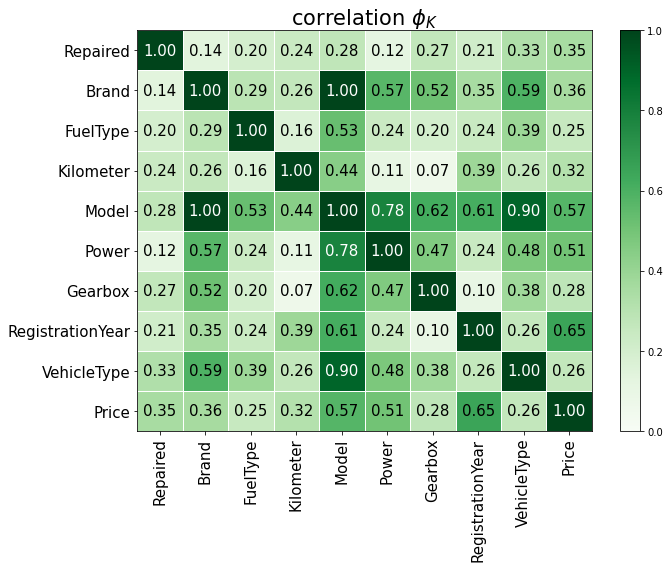

In [55]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Выявленая прямая полная корреляция между признаками Model и Brand.  
Также Model также сильно коррелирует с признаком VehicleType. 

Удалю признак Model для наилучшего расчета моделей.

In [56]:
data.drop('Model', axis=1, inplace=True)

#### Подготовим данные к обучению

In [57]:
# Разобьем данные на обучающие признаки и целевой
features = data.drop('Price', axis=1)
target = data.Price

In [58]:
for col in features.select_dtypes(include=['object']):
    features[col] = features[col].astype('category')

создам копию данных, чтобы закодировать категориальные признакми для get_dummy

In [59]:
features_dummy = features.copy()
target_dummy = target.copy()

In [60]:
features_dummy = pd.get_dummies(features_dummy, columns=['VehicleType','Gearbox','FuelType', 'Brand','Repaired', 'Kilometer'], drop_first=True)

In [61]:
# разобьем данные на тренировочну и временную выборки. Временную после разделим на валидационную и тестовую
features_train, features_temp, target_train, target_temp = train_test_split(features,target, test_size=0.4)

In [62]:
features_valid, features_test, target_valid, target_test = train_test_split(features_temp,target_temp, test_size=0.5)

создадим копии выборок для дальшейшего кодирования разными алгоритамами, чтобы использовать их в обучении разных моделей

In [63]:
features_train_ordinal = features_train.copy()
features_valid_ordinal = features_valid.copy()
features_test_ordinal = features_test.copy()

#### Создадим переменную, в которой укажем названия категориальных признаков

In [64]:
categorial_features = ['VehicleType','Gearbox','Brand', 'FuelType','Repaired', 'Kilometer']

#### Произведу кодирование категориальных признаков алгоритмом **OrdinalEncoder**

In [67]:
encoder = OrdinalEncoder(handle_unknown='error', unknown_value=None)

In [68]:
encoder.fit(features_train_ordinal[categorial_features])

OrdinalEncoder()

Применим кодирование категориальных признаков методом OrdinalEncoder

In [69]:
features_train_ordinal[categorial_features] = encoder.transform(features_train_ordinal[categorial_features])
features_valid_ordinal[categorial_features] = encoder.transform(features_valid_ordinal[categorial_features])
features_test_ordinal[categorial_features] = encoder.transform(features_test_ordinal[categorial_features])

Применим кодирование категориальных признаков методом get_dummy

In [70]:
#разобьем данные на тренировочные, валидационные и тестовые выборки. Будем использовать датасет, к которому ранее уже преминили get_dummies
features_train_dummy, features_temp_dummy, target_train_dummy, target_temp_dummy = train_test_split(features_dummy,target_dummy, test_size=0.4)
features_valid_dummy, features_test_dummy, target_valid_dummy, target_test_dummy = train_test_split(features_temp_dummy,target_temp_dummy, test_size=0.5)

In [71]:
# создадим переменную с числовыми данными, чтобы применить к ним стандартизацию
numeric = ['RegistrationYear', 'Power']

Произведем стандартизацию для данных закодированных Ordinal и Dummy

In [72]:
scaler = StandardScaler()

In [73]:
scaler.fit(features_train_ordinal[numeric])

StandardScaler()

In [74]:
features_train_ordinal[numeric] = scaler.transform(features_train_ordinal[numeric])
features_valid_ordinal[numeric] = scaler.transform(features_valid_ordinal[numeric])
features_test_ordinal[numeric] = scaler.transform(features_test_ordinal[numeric])

In [75]:
scaler.fit(features_train_dummy[numeric])

StandardScaler()

In [76]:
features_train_dummy[numeric] = scaler.transform(features_train_dummy[numeric])
features_valid_dummy[numeric] = scaler.transform(features_valid_dummy[numeric])
features_test_dummy[numeric] = scaler.transform(features_test_dummy[numeric])

## Обучение моделей

### Создадим модели обучения

In [77]:
# зададим параметры для модели LGBMRegressor
n_estimators =  [100, 500, 1000]
learning_rate = [0.01, 0.1]#, 0.5]

In [78]:
model_linear = LinearRegression() # модель линейной регрессии
model_rf = RandomForestRegressor(random_state=12345) # модель случайного леса
model_cat = CatBoostRegressor(loss_function='RMSE')  # модель CatBoost

# создадим словарь, который будет хранить модели LGBMRegressor с разными гиперпараметрами
model_lgbm_dict = dict()
for i in n_estimators:
    for y in learning_rate:
        model_lgbm_dict[i,y] = LGBMRegressor(n_estimators = i, learning_rate=y) # модель LightGBM

In [79]:
model_lgbm_dict

{(100, 0.01): LGBMRegressor(learning_rate=0.01),
 (100, 0.1): LGBMRegressor(),
 (500, 0.01): LGBMRegressor(learning_rate=0.01, n_estimators=500),
 (500, 0.1): LGBMRegressor(n_estimators=500),
 (1000, 0.01): LGBMRegressor(learning_rate=0.01, n_estimators=1000),
 (1000, 0.1): LGBMRegressor(n_estimators=1000)}

In [80]:
# создадим таблицу для сохранения результатов работы LGBMRegressor
model_lgbm_result = pd.DataFrame(index = model_lgbm_dict.keys(), columns=['params', 'RMSE', 'time_fit', 'time_predict'])
model_lgbm_result

params RMSE time_fit time_predict
100  0.01    NaN  NaN      NaN          NaN
     0.10    NaN  NaN      NaN          NaN
500  0.01    NaN  NaN      NaN          NaN
     0.10    NaN  NaN      NaN          NaN
1000 0.01    NaN  NaN      NaN          NaN
     0.10    NaN  NaN      NaN          NaN

### Обучим модель **LGBMRegressor** с разными гиперпараметрами, сохраним результаты в таблицу **model_lgbm_result**

In [81]:
del features, features_dummy, target, target_dummy

In [82]:
%%time
for i, model in model_lgbm_dict.items():
    predict = []
    print(i)
    model_lgbm_result.loc[i]['params'] = i
    model_study = model
    time_start = time.time() # фиксируем время начала обучения
    model_study.fit(features_train, target_train)
    model_lgbm_result.loc[i]['time_fit'] = round((time.time() - time_start),2) # сохраняем время обучение модели в датафрейм
    time_predict = time.time() # фиксируем время начала предсказания
    predict = model_study.predict(features_valid) # делаем предсказание
    model_lgbm_result.loc[i]['time_predict'] = round((time.time() - time_predict),2)
    rmse = mean_squared_error(target_valid, predict)**0.5 # рассчитываем метрику RMSE
    model_lgbm_result.loc[i]['RMSE'] = round(rmse,2) # сохраняем параметр RMSE в датафрейм

(100, 0.01)
(100, 0.1)
(500, 0.01)
(500, 0.1)
(1000, 0.01)
(1000, 0.1)
CPU times: total: 4min 29s
Wall time: 1min 13s


In [83]:
model_lgbm_result = model_lgbm_result.sort_values(by='RMSE', ascending=True)
model_lgbm_result

,,params,RMSE,time_fit,time_predict
1000,0.10,"(1000, 0.1)",1601.02,12.34,7.81
500,0.10,"(500, 0.1)",1612.37,6.55,1.85
1000,0.01,"(1000, 0.01)",1678.15,15.93,9.15
100,0.10,"(100, 0.1)",1681.18,2.9,0.32
500,0.01,"(500, 0.01)",1729.82,10.28,3.11
100,0.01,"(100, 0.01)",2646.58,2.94,0.29


получили лучший результат работы **LGBMRegressor** на гиперпараметрах:  
n_estimators = 1000
learning_rate = 0.1

### Обучим модели линейной регрессии, случайного леса и CatBoost

In [84]:
dict = {'linear' : model_linear,
       'RF' : model_rf,
        'CatBoost' : model_cat
       }

In [85]:
# Создадим датафрейм для дальнейшего сохранения результатов
results = pd.DataFrame(index = dict.keys(), columns=['model', 'RMSE', 'time_fit', 'time_predict'])
results

,model,RMSE,time_fit,time_predict
linear,NaN,NaN,NaN,NaN
RF,NaN,NaN,NaN,NaN
CatBoost,NaN,NaN,NaN,NaN


In [86]:
# в цикле поочередно обучим модели, сохраним время их обучения и метрику RMSE
for i, model in dict.items():
    predict = []
    results.loc[i]['model'] = i
    model_study = model

    if i == 'linear':
        time_start = time.time() # фиксируем время начала обучения
        model_study.fit(features_train_dummy, target_train_dummy)
        results.loc[i]['time_fit'] = round((time.time() - time_start),2) # сохраняем время обучение модели в датафрейм
        time_predict = time.time()
        predict = model_study.predict(features_valid_dummy) # делаем предсказание
        results.loc[i]['time_predict'] = round((time.time() - time_predict),2)
    
        rmse = mean_squared_error(target_valid_dummy, predict)**0.5 # рассчитываем метрику RMSE
        results.loc[i]['RMSE'] = round(rmse,2) # сохраняем параметр RMSE в датафрейм
        continue 
    elif i == "CatBoost":
        pool_train = Pool(features_train, target_train,
                  cat_features = categorial_features)
        pool_test = Pool(features_valid, cat_features = categorial_features)
        
        time_start = time.time() # фиксируем время начала обучения
        model_study.fit(pool_train, verbose=50)
        results.loc[i]['time_fit'] = round((time.time() - time_start),2) # сохраняем время обучение модели в датафрейм
        time_predict = time.time()
        predict = model_study.predict(pool_test) # делаем предсказание
        results.loc[i]['time_predict'] = round((time.time() - time_predict),2)
        rmse = mean_squared_error(target_valid, predict)**0.5 # рассчитываем метрику RMSE
        results.loc[i]['RMSE'] = round(rmse,2) # сохраняем параметр RMSE в датафрейм
    else:
        time_start = time.time() # фиксируем время начала обучения
        model_study.fit(features_train_ordinal, target_train)
        results.loc[i]['time_fit'] = round((time.time() - time_start),2) # сохраняем время обучение модели в датафрейм
        time_predict = time.time()
        predict = model_study.predict(features_valid_ordinal) # делаем предсказание
        results.loc[i]['time_predict'] = round((time.time() - time_predict),2)
        rmse = mean_squared_error(target_valid, predict)**0.5 # рассчитываем метрику RMSE
        results.loc[i]['RMSE'] = round(rmse,2) # сохраняем параметр RMSE в датафрейм

Learning rate set to 0.090672
0:	learn: 4388.9582435	total: 971ms	remaining: 16m 9s
50:	learn: 1881.0219436	total: 18.2s	remaining: 5m 39s
100:	learn: 1786.4593163	total: 36.7s	remaining: 5m 26s
150:	learn: 1745.7137889	total: 56.7s	remaining: 5m 18s
200:	learn: 1720.5271258	total: 1m 14s	remaining: 4m 57s
250:	learn: 1702.3222700	total: 1m 34s	remaining: 4m 41s
300:	learn: 1687.5412452	total: 1m 51s	remaining: 4m 18s
350:	learn: 1674.9975502	total: 2m 9s	remaining: 3m 58s
400:	learn: 1663.5281460	total: 2m 27s	remaining: 3m 40s
450:	learn: 1653.4830906	total: 2m 45s	remaining: 3m 20s
500:	learn: 1646.7566819	total: 3m 2s	remaining: 3m 1s
550:	learn: 1638.8059182	total: 3m 19s	remaining: 2m 42s
600:	learn: 1632.1657351	total: 3m 36s	remaining: 2m 23s
650:	learn: 1625.4117724	total: 3m 57s	remaining: 2m 7s
700:	learn: 1618.9748309	total: 4m 14s	remaining: 1m 48s
750:	learn: 1613.0245010	total: 4m 32s	remaining: 1m 30s
800:	learn: 1607.7265774	total: 4m 50s	remaining: 1m 12s
850:	learn: 

## Анализ моделей

Добавим результаты работы модели **LightGBM** с наилучшим RMSE после подборки параметров в таблицу общими результатами

In [87]:
best_lgbm = pd.DataFrame(model_lgbm_result.values[0][1:]).T # первая строка из отсортированной таблицы с результатами работы LightGBM

best_lgbm = best_lgbm.rename(index={0: 'LightGBM'}).reset_index() # установим индекс название нашей модели

# приведем название столбцов
best_lgbm.rename(columns={'index': 'model', 
                         0 : 'RMSE',
                         1 : 'time_fit',
                         2 : 'time_predict'}, inplace=True)
best_lgbm

,model,RMSE,time_fit,time_predict
0,LightGBM,1601.02,12.34,7.81


In [88]:
results.reset_index(drop=True, inplace=True)
results =  results.append(best_lgbm, ignore_index = True ) 
results

,model,RMSE,time_fit,time_predict
0,linear,2715.93,2.78,0.1
1,RF,1707.3,130.04,4.17
2,CatBoost,1648.36,366.16,0.43
3,LightGBM,1601.02,12.34,7.81


Отсортируем получившиеся результаты по наилучшему показателю показателю RMSE

In [89]:
res = results.sort_values(by='RMSE', ascending=True)
res

,model,RMSE,time_fit,time_predict
3,LightGBM,1601.02,12.34,7.81
2,CatBoost,1648.36,366.16,0.43
1,RF,1707.3,130.04,4.17
0,linear,2715.93,2.78,0.1


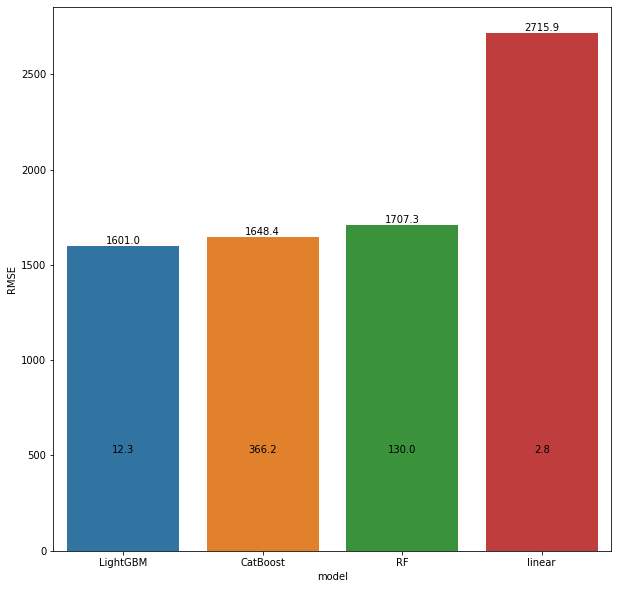

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(data=res, x='model', y='RMSE')
for i, rmse in enumerate(res.RMSE):
    ax.text(i,rmse,round(rmse, 1),  verticalalignment='bottom', horizontalalignment='center')
for i, time in enumerate(res.time_fit):
    ax.text(i,500,round(time, 1),  verticalalignment='bottom', horizontalalignment='center')    

Вывод - из графика видно, что:
Модель линейной регрессии не подходит, т.к. показатель RMSE превышает установленный условием задачи 2500.
Показатель **RMSE**: модель **LightGBM** имеет наилучшее значение RMSE на валидационной выборке, **CatBoost** на втором, **RF** на третьем.  
Время обучения: На первом месте модель **RF**, на втором месте с небольшим отстванием **LightGBM**, на третьем **CatBoost**.
Время предсказания: На первом месте модель **CatBoost**, на втором месте **RF**, на третьем **LightGBM**.


Учитывая, что модель **LightGBM** показала наилучший результат **RMSE** и второй результат по времени обучения - для целей заказчика будем использовать ее. 

Применим "лучшую модель" на тестовых данных:

In [91]:
%%time
model_lgbm_dict[(1000, 0.1)].predict(features_test)

CPU times: total: 29.7 s
Wall time: 7.62 s


array([15339.22078527, 13163.63619758,  1385.39775857, ...,
         817.86082261,  7851.11473034,   847.81894308])

Рассчитываем метрику RMSE на тестовых данных

In [92]:
rmse = mean_squared_error(target_valid, predict)**0.5 
rmse

1648.3627786307009

## Вывод

В нашем распоряжении были данные из объявлений о продаже автомобилей.
Необходимо было построить модель обучения для эффективного определения стоимости автомобиля. 
Стояла целевая задача выбрать наилучшую модель предсказания с метрикой RMSE до 2500 и скорости обучения

В ходе работы над проектом была осуществлена предобработка данных, проверка на дубликаты, работа с аномальными значениями.

В результате проверки на корреляцию была выявлена полная прямая корреляция между признаками Model и Bramd, а также Model и  VehicleType, в результате чего для исследования был удален признак Model.  
Также были удалены неинформативные признаки: **'DateCrawled','NumberOfPictures','RegistrationMonth','DateCreated','PostalCode','LastSeen'**


В результате выполнения работы мы рассмотрели работу нескольких моделей машиного обучения:
- линейная регрессия;
- случайный лес;
- LightGBM;
- СatBoost.

Для обучения двух моделей LightGBM и СatBoost использовались данные без кодирования категориальных признаков, т.к. эти модели позволяют передавать такие признаки напрямую.

Для модели Случайный лес было применено OrdinalEncoder, для линейной регрессии OneHotEncoder.


При проверке на валидационных данных наилучший результат по показателю RMSE показала модель: .  
По скорости обучения наилучший результат показала модель случайного леса, LightGBM занял второе место.
В результате анализа для целей заказчика было принято использовать модель LightGBM.

При проверке на тестовых данных был получен следующий результат работы модели: 
- Целевая метрика RMSE 1648,36
- время предсказания 7,62 секунды

Целевая задача, выполнена.